In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from statistics import mean
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
def getDataset():
    """ Load the dataset and Returns dataframes of Input matrix (X) and Output labels (y)
        Return: dataset"""
    
    # Load the dataset from spambase.data
    dataframe = pd.read_csv('spambase.data', header=None)
    X = dataframe.drop(57, axis=1)
    y = dataframe[57]
    
    ### Storing the dataset values
    dataset = (X, y)
#     with open('dataset.pkl', 'wb') as fout:
#         pickle.dump(dataset, fout)
    return dataset

In [3]:
def getScore(model, X_train, X_test, y_train, y_test):
    """ Train the dataset on the given model and evaluate score on the test set
        Input:
            model: Classification Model
            X_train: training input for training
            X_test: training input for testing
            y_train: output labels for training
            y_test: output labels for testing
        Return: accuracy score of the model """
    
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [4]:
def evaluate(model, kfold, X, y):
    """ Evaluate the model for given dataset using k-fold Cross-Validation
        Input:
            model: Classification Model
            kfold: number of split of the dataset for cross validation
            X: input data
            y: output labels
        Return: average scores"""
    
    # score list to store all the eval score
    scores = []
    
    # split the training and testing dataset into k-folds using StratifiedKFold
    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=1)
    for train_idx, test_idx in folds.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        scores.append(getScore(model, X_train, X_test, y_train, y_test))
    
    return mean(scores)

In [5]:
def modelEstimation():
    """ To estimate performance of various model
        All the kfold values used below are assigned after iteratively checking the accuracy of the model"""
    
    # Extract dataset
    X, y = getDataset()
    
    ### Evaluate spam dataset on various Classifier
    print('Logistic Regression Classification:')
    acc_log = evaluate(LogisticRegression(), 10, X, y)
    print(acc_log)
    print('SVM Classification:')
    acc_svc = evaluate(SVC(), 10, X, y)
    print(acc_svc)
    print('Decision Tree Classification:')
    acc_dtc = evaluate(DecisionTreeClassifier(), 10, X, y)
    print(acc_dtc)
    print('RandomForest Classification:')
    acc_rf = evaluate(RandomForestClassifier(n_estimators=25), 10, X, y)
    print(acc_rf)
    print('Best result is observed from Random Forest: ', acc_rf, '\n')
    
    ### Another effective approach to evaluate a model using cross_val_score method
    print('Evaluate models using cross_val_score()')
    print('Logistic Regression Classification using cross_val_score():')
    score_lr = mean(cross_val_score(LogisticRegression(), X, y, cv=10))
    print(score_lr)
    print('SVM Classification using cross_val_score():')
    score_svc = mean(cross_val_score(SVC(), X, y, cv=10))
    print(score_svc)
    print('Decision Tree Classification using cross_val_score():')
    score_dt = mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10))
    print(score_dt)
    print('RandomForest Classification using cross_val_score():')
    score_rf = mean(cross_val_score(RandomForestClassifier(n_estimators=25), X, y, cv=10))
    print(score_rf)
    print('Best result is observed from Random Forest (using cross_val_score()): ', score_rf, '\n')
    
modelEstimation()

Logistic Regression Classification:
0.9280612579947674
SVM Classification:
0.8384958412929131
Decision Tree Classification:
0.9169733295772541
RandomForest Classification:
0.9534880733183377
Best result is observed from Random Forest:  0.9534880733183377 

Evaluate models using cross_val_score()
Logistic Regression Classification using cross_val_score():
0.9162903950602216
SVM Classification using cross_val_score():
0.8152513943005812
Decision Tree Classification using cross_val_score():
0.9008508474910604
RandomForest Classification using cross_val_score():
0.936722385266471
Best result is observed from Random Forest (using cross_val_score()):  0.936722385266471 



In [6]:
def evaluation(model, X, y, kfold):
    """Evaluate the Dataset using RandomForest Model
        Input:
            model: training model
            X: input data
            y: output labels
            kfold: number of split of the dataset for cross validation"""
    
    # Estimation parameters
    scores, error = list(), list()
    fal_pos, fal_neg = list(), list()
    
    # Split data into K-folds
    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=1)
    for train_idx, test_idx in folds.split(X, y):
        # Divide the data and calculate the score
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        scores.append(getScore(model, X_train, X_test, y_train, y_test))
        
        # predict the model on testing data and evaluate prediction, confusion matrix, fn, fp and error
        prediction = model.predict(X_test)
        conf_mat = confusion_matrix(y_test, prediction)
        tn, fp, fn, tp = conf_mat.ravel()
        fal_pos.append(fp)
        fal_neg.append(fn)
        error.append(1-accuracy_score(y_test, prediction))
        
        # Plot the confusion matrix
        plt.figure(figsize=(3,3))
        sn.heatmap(conf_mat, annot=True)
        plt.xlabel('Predicated')
        plt.ylabel('Truth')
        
    # Compute the overall Score, FP, FN, Error
    print('\nOverall Score: ', mean(scores))
    print('Overall False Positive: ', mean(fal_pos))
    print('Overall False Negative: ', mean(fal_neg))
    print('Overall Error: ', mean(error))
    
    # Table for FP, FN, Error at every iteration
    overall_fp, overall_fn, overall_error = mean(fal_pos), mean(fal_neg), mean(error)
    result = pd.DataFrame(np.column_stack([fal_pos, fal_neg, error]), columns=['False Positive', 'False Negative', 'Error Rate'])
    print('\nResultant Table of FP, FN, Error')
    print(result)
    
    # Score, FP, FN, Error fold-wise
    print('\nScore across all folds: ', scores)
    print('False Positive across all folds: ', fal_pos)
    print('False Negative across all folds: ', fal_neg)
    print('Error across all folds: ', error)

In [7]:
def main(argv):
    """ Load dataset and evaluate on various classification models
        All the kfold values used below are assigned after iteratively checking the accuracy of the model"""
    
    ### Read Dataset
    X, y = getDataset()
    
    ### Estimate accuracy of different classification models
    ### modelEstimation(X, y)
    
    ### Using Random Forest Classifier for the Error Estimation
    evaluation(RandomForestClassifier(n_estimators=25), X, y, 10)
    


Overall Score:  0.9537040478739831
Overall False Positive:  8
Overall False Negative:  13
Overall Error:  0.04629595212601686

Resultant Table of FP, FN, Error
   False Positive  False Negative  Error Rate
0             7.0            14.0    0.045553
1            10.0            10.0    0.043384
2            10.0            12.0    0.047722
3             7.0            15.0    0.047826
4             9.0            12.0    0.045652
5            11.0             8.0    0.041304
6             7.0            18.0    0.054348
7             8.0            10.0    0.039130
8             7.0            14.0    0.045752
9             7.0            17.0    0.052288

Score across all folds:  [0.9544468546637744, 0.9566160520607375, 0.9522776572668112, 0.9521739130434783, 0.9543478260869566, 0.9586956521739131, 0.9456521739130435, 0.9608695652173913, 0.954248366013072, 0.9477124183006536]
False Positive across all folds:  [7, 10, 10, 7, 9, 11, 7, 8, 7, 7]
False Negative across all folds:  [14, 

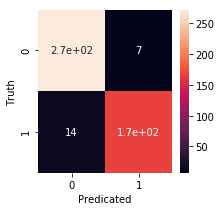

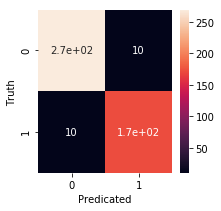

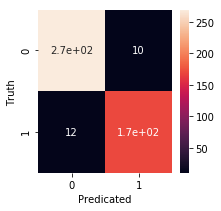

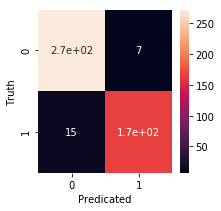

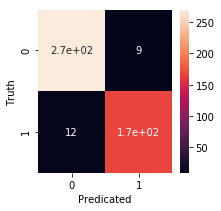

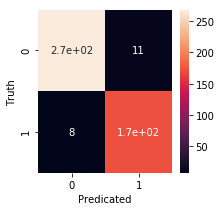

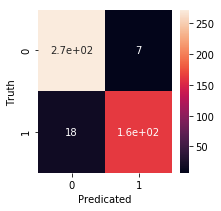

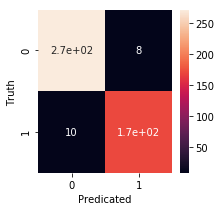

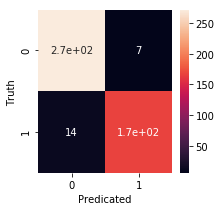

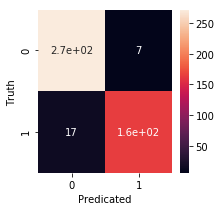

In [8]:
if __name__ == '__main__':
    main([])